<a href="https://colab.research.google.com/github/TehLedRed/SpringerManuscript/blob/main/Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import math
import keras
from scipy import optimize
from scipy.stats import expon
import os.path
import matplotlib.pyplot as plt
!pip install ipython-autotime
%load_ext autotime
!pip install import-ipynb
import import_ipynb
from google.colab import output
output.clear()

time: 6.82 s (started: 2023-10-23 23:22:36 +00:00)


In [ ]:
%cd /content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial
import nbCure

/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial
importing Jupyter notebook from nbCure.ipynb
time: 1.79 s (started: 2023-10-23 23:23:01 +00:00)


In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()


time: 688 µs (started: 2023-10-23 23:23:04 +00:00)


# Load data and preprocessing

In [ ]:
dataTrain = pd.read_csv("/content/drive/MyDrive/Mestrado/PCM/data/trainSet.csv")  # n=280
dataTest = pd.read_csv("/content/drive/MyDrive/Mestrado/PCM/data/testSet.csv")

mri = np.load("/content/drive/MyDrive/Mestrado/PCM/data/mri.npz")
mriTrain = mri["train_images"]
mriTest = mri["test_images"]

time: 4.47 s (started: 2023-10-23 23:23:06 +00:00)


Remove outlier and normalize images data.

In [ ]:
mriTrain = np.delete(mriTrain, 230, axis=0)

imgTrain = (mriTrain/2240).astype(np.float32)
imgTest = (mriTest/2240).astype(np.float32)

time: 123 ms (started: 2023-10-23 23:23:12 +00:00)


In [ ]:
timeTrain = tf.constant(dataTrain.time, dtype=tf.float32, shape=[280,1])
timeTest = tf.constant(dataTest.time, dtype=tf.float32, shape=[72,1])

deltaTrain = tf.constant(dataTrain.delta, dtype=tf.float32, shape=[280,1])
deltaTest = tf.constant(dataTest.delta, dtype=tf.float32, shape=[72,1])

time: 3.2 s (started: 2023-10-23 23:23:12 +00:00)


## Auxiliary functions

### Susceptible individuals

1. Calculate $g$ interval times

In [ ]:
@tf.function
def calc_mat(t):
    '''
    Returns two matrices for later use in alpha estimation, each matrix's
    shape equals to (#of indivuals x 5) as J = 5.
    '''
    g = tf.constant(
        [0.95342463, 2.06191778, 3.35999999, 4.49534245, 6.32000008, 12.2],
        shape=(1,6))

    t1 = t - g[:,:-1]
    t2  = g[:,1:] - g[:,:-1]

    indicator2 = t > g[:,1:]
    cat = tf.reduce_sum(tf.cast(indicator2, dtype=tf.float32), axis=1)
    indicator1 = tf.one_hot(tf.cast(cat, dtype=tf.int32), depth=5)

    num = indicator1
    denom = tf.add(indicator1*t1, indicator2*t2)

    return num, denom

time: 1.53 ms (started: 2023-10-23 23:24:09 +00:00)


### Accuracy metric - imputed AUC

In [ ]:
def aucFI(eta, phi):
  theta = np.exp(eta)
  term = 1 + phi*theta
  pc = np.power(term, -(1/phi))

  seq = np.arange(0,1,0.01)
  TPR = []
  FPR = []

  for i in seq:
    TPR.append(np.sum(np.where(pc <= i, 1, 0) * (1-pc))/ np.sum(1-pc))
    FPR.append(np.sum(np.where(pc <= i, 1, 0) * pc)/ np.sum(pc))

  TPR = np.array(TPR)
  FPR = np.array(FPR)

  return np.sum((TPR[:-1] + TPR[1:])*(FPR[1:] - FPR[:-1])*0.5)

time: 730 µs (started: 2023-10-23 23:24:15 +00:00)


In [ ]:
def doPlot(train_loss_results, train_accuracy_results, test_loss_results, test_accuracy_results):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
    # fig.suptitle('On train set')

    ax1.set_ylabel("Loss", fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=14)
    ax1.plot(train_loss_results, label='Train')
    ax2.set_ylabel("AUC", fontsize=14, )
    ax2.set_xlabel("EM iteration", fontsize=14)
    ax2.plot(train_accuracy_results, label='Train')

    #ax1.axhline(loss_t.numpy(), color="r", linestyle="--")
    ax1.set_ylabel("Loss", fontsize=14)
    ax1.set_xlabel("Epoch", fontsize=14)
    ax1.plot(test_loss_results, 'tab:orange', label='Test')

    ax2.set_ylabel("AUC", fontsize=14)
    ax2.set_xlabel("EM iteration", fontsize=14)
    ax2.plot(test_accuracy_results, 'tab:orange', label='Test')
    ax1.legend()
    ax2.legend()

    plt.show()

time: 1.32 ms (started: 2023-10-23 23:29:07 +00:00)


### Convolutional neural network

Subclassing keras.Model class

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=4,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.leaky_relu,
            dtype=tf.float32,
            name="Convolution-1"
        )
        self.pool1 = tf.keras.layers.MaxPool2D(
            pool_size=[2, 2],
            strides=2,
            name="Pooling-1")
        self.conv2 = tf.keras.layers.Conv2D(
            filters=12,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.leaky_relu,
            dtype=tf.float32,
            name="Convolution-2"
        )
        self.pool2 = tf.keras.layers.MaxPool2D(
            pool_size=[2, 2],
            strides=2,
            name="Pooling-2")
        self.conv3 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.leaky_relu,
            dtype=tf.float32,
            name="Convolution-3"
        )
        self.pool3 = tf.keras.layers.MaxPool2D(
            pool_size=[2, 2],
            strides=2,
            name="Pooling-3")

        self.flatten = tf.keras.layers.Reshape(target_shape=(-1,), name="Flatten")
        self.dense2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh, dtype=tf.float32, name="Dense")
        self.dense3 = tf.keras.layers.Dense(dtype=tf.float32, units=1, activation=None, use_bias=False, name="Output")
        # self.dropout = tf.keras.layers.Dropout(0.2, noise_shape=None, seed=2022)

    def call(self, input_img):
        # inputs = tf.reshape(input_img, [-1, 160, 200, 1])
        x = self.conv1(input_img)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dense2(x)

        return self.dense3(x)

    def build_graph(self):
        x = tf.keras.Input(shape=(160, 200, 1))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))



time: 2.85 ms (started: 2023-10-23 23:24:56 +00:00)


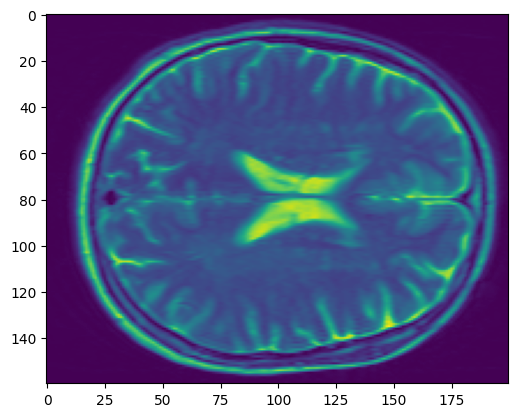

time: 341 ms (started: 2023-10-13 02:42:01 +00:00)


In [ ]:
plt.imshow(imgTrain[0][:, :, 0])

# Print model summary and graph

In [ ]:
matNumTrain, matDenomTrain = calc_mat(timeTrain)
matNumTest, matDenomTest = calc_mat(timeTest)

time: 209 ms (started: 2023-10-23 23:26:02 +00:00)


In [ ]:
temp = matNumTrain*deltaTrain
tf.reduce_sum(temp, axis = 0)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([11., 10., 10., 10., 11.], dtype=float32)>

time: 13.3 ms (started: 2023-10-15 14:25:37 +00:00)


In [ ]:
phi = 0.01

model = Model()
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
mi = deltaTrain + 1e-2

alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
alpha_record = alpha.numpy().copy()
S1 = nbCure.calc_S1(alpha, matDenomTrain)

with tf.GradientTape() as tape:
  loss = nbCure.calcNBL1(mi, phi, model(imgTrain))
  print("iter %d: loss %f" % (1, loss.numpy()))

iter 1: loss 0.980459
time: 170 ms (started: 2023-10-15 14:27:47 +00:00)


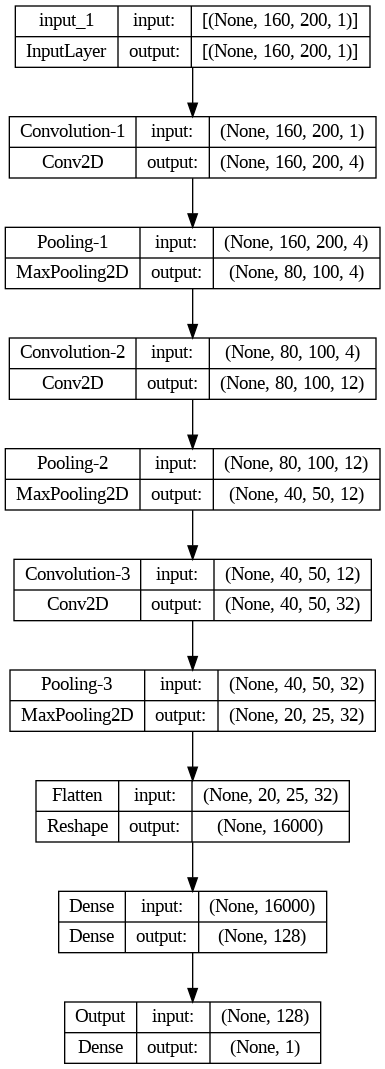

time: 1.15 s (started: 2023-10-15 14:27:54 +00:00)


In [ ]:
from keras.utils import plot_model
plot_model(model.build_graph(), show_shapes=True, show_layer_names=True)

In [ ]:
model.summary(
    line_length=None,
    positions=None,
    print_fn=None,
    expand_nested=True,
    show_trainable=False,
)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolution-1 (Conv2D)      multiple                  104       
                                                                 
 Pooling-1 (MaxPooling2D)    multiple                  0         
                                                                 
 Convolution-2 (Conv2D)      multiple                  1212      
                                                                 
 Pooling-2 (MaxPooling2D)    multiple                  0         
                                                                 
 Convolution-3 (Conv2D)      multiple                  9632      
                                                                 
 Pooling-3 (MaxPooling2D)    multiple                  0         
                                                                 
 Flatten (Reshape)           multiple                  0   

# Grid  search

## Function

In [ ]:
def runNB(phigrid, outcome = False):
  params = []
  train_loss_results = []
  train_accuracy_results = []
  test_loss_results = []
  test_accuracy_results = []
  for i in range(len(phigrid)):#range(1): #

    phi = phigrid[i] #0.03#

    model = Model()
    optimizer = tf.optimizers.Adam(learning_rate=0.0001)

    mi = deltaTrain + 1e-2
    alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
    alpha_record = alpha.numpy().copy()
    S1 = nbCure.calc_S1(alpha, matDenomTrain)

    with tf.GradientTape() as tape:
      loss = nbCure.calcNBL1(mi, phi, model(imgTrain))
      print("iter %d: loss %f" % (1, loss.numpy()))

    grads = tape.gradient(loss, sources = model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    var_list = []
    for l in range(len(model.variables)):
        var_list.append(tf.squeeze(model.variables[l]).numpy())
    var_record = np.concatenate(list(map(lambda x: x.reshape(-1), var_list))).copy()

    # second run ---------------------------------------------------
    eps = 1
    num_iter = 1

    while eps > 1e-6 and num_iter <= 30:
      min_loss = 10.
      early_stopping_at = 1
      count_patience = 0
      patience = 5

      # 1. first updating mi
      mi = nbCure.calcM(deltaTrain, phi, tf.math.exp(model(imgTrain)), S1)

      # 2. updating alpha, S1
      alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
      S1 = nbCure.calc_S1(alpha, matDenomTrain)

      # calculations for test set
      S1_t = nbCure.calc_S1(alpha, matDenomTest)
      mi_t = nbCure.calcM(deltaTest, phi, tf.math.exp(model(imgTest)), S1_t)

      for epoch in range(1, 101):
          # 3. updating network parameters
          with tf.GradientTape() as tape:
              loss = nbCure.calcNBL1(mi, phi, model(imgTrain))
              loss_t = nbCure.calcNBL1(mi_t, phi, model(imgTest))

          if epoch % 250 == 0:
              print("# %d: loss %4f, loss_t %4f" % (num_iter, loss.numpy(), loss_t.numpy()))

          grads = tape.gradient(loss, sources=model.variables)
          optimizer.apply_gradients(zip(grads, model.variables))

          # termination conditions
          if loss_t < min_loss:
              min_loss = loss_t.numpy().copy()
              early_stopping_at = epoch
              best_variable = model.variables
              count_patience = 0
              if outcome:
                train_loss_results.append(loss.numpy())
                test_loss_results.append(loss_t.numpy())

          else:
              count_patience += 1

          if count_patience > patience:
              print("break, converged")
              for i in range(len(model.variables)):
                  model.variables[i].assign(best_variable[i])
              break

      # 4. Record changes in losses
      var_list = []
      for l in range(len(model.variables)):
          var_list.append(tf.squeeze(model.variables[l]).numpy())
      var_new = np.concatenate(list(map(lambda x: x.reshape(-1), var_list))).copy()

      eps = np.mean((var_new - var_record)**2) + np.mean((alpha-alpha_record)**2)
      var_record = var_new.copy()
      alpha_record = alpha.numpy().copy()

      if outcome:
        train_accuracy_results.append(aucFI(model(imgTrain), phi))
        test_accuracy_results.append(aucFI(model(imgTest), phi))
      print("# %d ε: %6f, early stops @E%d" % (num_iter, eps, early_stopping_at))

      # 5. iteration +1
      num_iter += 1

    # 1. first updating mi
    S1 = nbCure.calc_S1(alpha, matDenomTrain)
    mi = nbCure.calcM(deltaTrain, phi, tf.math.exp(model(imgTrain)), S1)
    alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
    S1 = nbCure.calc_S1(alpha, matDenomTrain)

    S1_t = nbCure.calc_S1(alpha, matDenomTest)
    mi_t = nbCure.calcM(deltaTest.numpy(), phi, tf.math.exp(model(imgTest)), S1_t)

    eta = model(imgTrain).numpy()
    eta_t = model(imgTest).numpy()

    LL = nbCure.observedLL(eta = eta_t,
                          F1 = 1 - S1_t,
                          f1 = nbCure.calc_f1(matNumTest, alpha, S1_t),
                          phi = phi,
                          delta = deltaTest)


    param = tf.squeeze(alpha).numpy()
    auc = aucFI(eta_t, phi)
    params.append(np.append([phi, LL, auc], param))

    tab = pd.DataFrame(params, columns=["phi", "Obs", "auc", "1", "2", "3", "4", "5"])
    print(tab)

    resTrain = pd.DataFrame(np.concatenate([eta, mi.numpy(), S1.numpy()], axis=1), columns=['eta', 'mi','S1'])
    print(resTrain.S1.describe())

    resTest = pd.DataFrame(np.concatenate([eta_t, mi_t.numpy(), S1_t.numpy()], axis=1), columns=['eta', 'mi', 'S1'])
    print(resTest.S1.describe())

    if outcome:
      return resTrain, resTest, param, train_loss_results, test_loss_results, train_accuracy_results, test_accuracy_results

time: 3.01 ms (started: 2023-10-23 23:25:37 +00:00)


## 1st search
    phi        Obs       auc
    0.1 -64.459717  0.801932

In [ ]:
phigrid = np.arange(0.1, 1.5, 0.1)
phigrid = tf.cast(phigrid, tf.float32)
print(phigrid)
runNB(phigrid = phigrid)

tf.Tensor([0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4], shape=(14,), dtype=float32)
iter 1: loss 1.016688
break, converged
# 1 ε: 0.015650, early stops @E2
break, converged
# 2 ε: 0.000557, early stops @E3
break, converged
# 3 ε: 0.000874, early stops @E1
break, converged
# 4 ε: 0.000133, early stops @E16
break, converged
# 5 ε: 0.000027, early stops @E9
break, converged
# 6 ε: 0.000012, early stops @E5
break, converged
# 7 ε: 0.000016, early stops @E3
break, converged
# 8 ε: 0.000022, early stops @E3
break, converged
# 9 ε: 0.000001, early stops @E3
break, converged
# 10 ε: 0.000022, early stops @E2
break, converged
# 11 ε: 0.000046, early stops @E2
break, converged
# 12 ε: 0.000019, early stops @E2
break, converged
# 13 ε: 0.000025, early stops @E2
break, converged
# 14 ε: 0.000012, early stops @E1
break, converged
# 15 ε: 0.000014, early stops @E1
break, converged
# 16 ε: 0.000014, early stops @E1
break, converged
# 17 ε: 0.000019, early stops @E1
break, converged
# 18 

## 2nd search
    phi        Obs       auc
    0.01 -65.571693  0.804655

In [ ]:
phigrid = np.linspace(start=0.01, stop=0.1, num=10)
phigrid = tf.cast(phigrid, tf.float32)
print(phigrid)
runNB(phigrid = phigrid)

tf.Tensor([0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ], shape=(10,), dtype=float32)
iter 1: loss 0.969095
break, converged
# 1 ε: 0.018562, early stops @E2
break, converged
# 2 ε: 0.000739, early stops @E14
break, converged
# 3 ε: 0.000027, early stops @E37
break, converged
# 4 ε: 0.000022, early stops @E4
break, converged
# 5 ε: 0.000027, early stops @E3
break, converged
# 6 ε: 0.000011, early stops @E3
break, converged
# 7 ε: 0.000048, early stops @E2
break, converged
# 8 ε: 0.000028, early stops @E2
break, converged
# 9 ε: 0.000040, early stops @E1
break, converged
# 10 ε: 0.000002, early stops @E1
break, converged
# 11 ε: 0.000007, early stops @E1
break, converged
# 12 ε: 0.000006, early stops @E1
break, converged
# 13 ε: 0.000075, early stops @E1
break, converged
# 14 ε: 0.000274, early stops @E1
break, converged
# 15 ε: 0.000042, early stops @E1
break, converged
# 16 ε: 0.000196, early stops @E2
break, converged
# 17 ε: 0.000143, early stops @E2
break, converged
# 18 ε: 0.

# Result

In [ ]:
resTrain, resTest, param, train_loss_results, test_loss_results, train_accuracy_results, test_accuracy_results = runNB(phigrid = [0.01], outcome = True)

iter 1: loss 1.020531
break, converged
# 1 ε: 0.007948, early stops @E1
break, converged
# 2 ε: 0.000367, early stops @E3
break, converged
# 3 ε: 0.001501, early stops @E1
break, converged
# 4 ε: 0.000073, early stops @E12
break, converged
# 5 ε: 0.000010, early stops @E8
break, converged
# 6 ε: 0.000007, early stops @E5
break, converged
# 7 ε: 0.000027, early stops @E3
break, converged
# 8 ε: 0.000085, early stops @E2
break, converged
# 9 ε: 0.000088, early stops @E2
break, converged
# 10 ε: 0.000007, early stops @E2
break, converged
# 11 ε: 0.000014, early stops @E2
break, converged
# 12 ε: 0.000023, early stops @E1
break, converged
# 13 ε: 0.000015, early stops @E1
break, converged
# 14 ε: 0.000018, early stops @E1
break, converged
# 15 ε: 0.000015, early stops @E1
break, converged
# 16 ε: 0.000006, early stops @E1
break, converged
# 17 ε: 0.000026, early stops @E1
break, converged
# 18 ε: 0.000013, early stops @E1
break, converged
# 19 ε: 0.000186, early stops @E1
break, converged


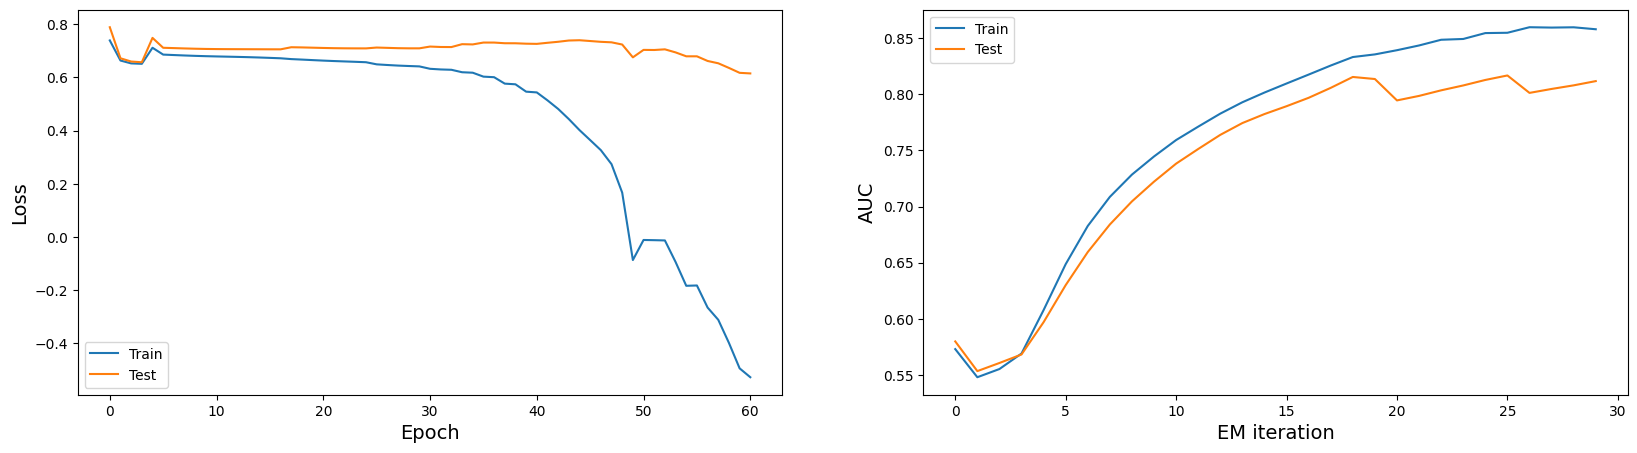

time: 460 ms (started: 2023-10-23 23:33:16 +00:00)


In [ ]:
doPlot(train_loss_results, train_accuracy_results, test_loss_results, test_accuracy_results)

In [ ]:
pd.DataFrame(param, index = range(1,6)).transpose()

,1,2,3,4,5
0,0.043662,0.06012,0.11356,0.168306,0.474769


time: 8.35 ms (started: 2023-10-23 23:33:21 +00:00)


In [ ]:
pd.DataFrame({"phi": 0.01, "AUC": [aucFI(resTrain.eta, 0.01)], "AUC test": [aucFI(resTest.eta, 0.01)]})

,phi,AUC,AUC test
0,0.01,0.857801,0.811639


time: 256 ms (started: 2023-10-23 23:33:24 +00:00)


In [ ]:
resTrain.to_csv("/content/drive/MyDrive/Mestrado/PCM/data/new/resTrain.csv", index=False)
resTest.to_csv("/content/drive/MyDrive/Mestrado/PCM/data/new/resTest.csv", index=False)
pd.DataFrame(
    np.append(param, 0.01),
    columns=['params'],
    index = ['1','2','3','4','5','phi']
).to_csv("/content/drive/MyDrive/Mestrado/PCM/data/new/alpha.csv", index=False)

time: 1.92 s (started: 2023-10-23 23:34:21 +00:00)
